# Libraries

In [22]:
from typing_extensions import Annotated, TypedDict, Optional, Dict
from langgraph.graph.message import add_messages, BaseMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
import os
from datetime import datetime
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from langchain_core.tools import tool
import csv

# Loading ENV


In [23]:
load_dotenv(dotenv_path=".env")

True

# Graph State


In [24]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    category: str
    context: str
    last_ai_message: Optional[str]
    system_prompt: str
    current_language: str
    previous_language: Optional[str]
    auto_mode: bool

# MEMORY


In [25]:
memory = MemorySaver()

# CSV File Loading

In [ ]:
CSV_FILE = "chamak_contacts.csv"

In [27]:
def init_csv():
    if not os.path.exists(CSV_FILE):
        with open(CSV_FILE, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["name", "phone_number", "address", "services", "total_cost", "timestamp"])

In [28]:
init_csv()

# Order Taking Tool


In [29]:
@tool
def save_contact_to_csv(name: str, phone_number: str, address: str, services: str, total_cost: str) -> str:
    """
    Save a user's order with his/her name, phone number, address, services and total cost to a CSV file.
    Call this tool ONLY when name, phone_number, address, services and total_cost are known and to record it.
    """
    with open(CSV_FILE, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([name, phone_number, address, services, total_cost, datetime.now().isoformat()])

    return "Contact saved successfully."

# Tool List


In [30]:
Tool = [save_contact_to_csv]

# LLM


In [31]:
llm = ChatOpenAI(
    api_key = os.getenv("MY_OPENAI_KEY"),
    model = "gpt-4.1-mini"
).bind_tools(tools=Tool)

In [32]:
embedding_tool = OpenAIEmbeddings(
    api_key=os.getenv("MY_OPENAI_KEY"),
    model="text-embedding-3-small"
)

# State Initializer


In [33]:
def init_state(state: State) -> State:
    if 'auto_mode' not in state:
        return {'auto_mode': True}

# Auto mode on-off

In [34]:
def mode_switch(state: State) -> State:
    query = state["messages"][-1].content
    if query == "/auto":
        return {'auto_mode' : True}
    elif query == "/manual":
        return {'auto_mode' : False}

# Auto/manual mode router

In [35]:
def mode_router(state: State) -> State:
    if state['auto_mode'] is True:
        return 'AI'
    else:
        return 'Human'

# Categorizer


In [ ]:
def prompt_categorizer(state: State) -> State:
    "To categorize the query done by the user"

    if state.get('last_ai_message') is None:
        prompt =  ChatPromptTemplate.from_template("""
        You are an experienced query categorizer for Chamak Bangladesh. Chamak is Bangladesh's premium home cleaning company which offers a range of professional cleaning services for homes-offices, chair, sofa, kitchen, carpet and bathroom. You will be given new user 'query', based on which you will identify which category the user's query belong. You will categorize in three ways -
        'irrelevant_query', 'general_query', 'service_query'.

        'irrelevant_query' -> Query which are not related to Chamak or its services.

        'general_query' -> Query which are related to general information, concern, policies, moto, ideology, contact information regarding Chamak. It can also provide the name of the services provided by Chamak but cannot provide in depth details.

        'service_query' -> Query which are trying to find information about in depth details about services provided by Chamak, like the price of particular service/services, tools/products used, team allocation for service, time required to complete services.

        Some examples are given below:
        'Tell me about Chamak pls' -> general_query.
        'What services/cleaning are done by Chamak' -> general_query.
        'Bathroom cleaning service price?' -> service_query.
        'Need Kitchen Cleaning' -> service_query.
        'hi' -> irrelevant_query.
        'tell me a kitchen cleaning joke/song' -> irrelevant_query.
        'i have a cat named cow' -> irrelevant_query.

        Now I am giving you the user 'query':

        query:
        {query}

        Just give me the category and nothing else.
        """)

        prompt_cateogrizer = prompt | llm
        result = prompt_cateogrizer.invoke({"query": state['messages']}).content

    else:
        prompt =  ChatPromptTemplate.from_template("""
        You are an experienced query categorizer using Chamak Bangladesh. Chamak is Bangladesh's premium home cleaning company which offers a range of professional cleaning services for homes-offices, chair, sofa, kitchen, carpet and bathroom. You will be given 'last_ai_message' of the agent and new user 'query', based on these two you will identify which category the user's query belong. Some 'query' will be follow up response of the 'last_ai_message' so keep that in mind. You will categorize in three ways -
        'irrelevant_query', 'general_query', 'service_query'.

        'irrelevant_query' -> Query which are not related to Chamak or its services.

        'general_query' -> Query which are related to general information, concern, policies, moto, ideology, contact information regarding Chamak. It can also provide the name of the services provided by Chamak but cannot provide in depth details.

        'service_query' -> Query which are trying to find information about in depth details about services provided by Chamak, like the price of particular service/services, tools/products used, team allocation for service, time required to complete services.

        Some examples are given below:
        'Tell me about Chamak pls' -> general_query.
        'What services/cleaning are done by Chamak' -> general_query.
        'Bathroom cleaning service price?' -> service_query.
        'Need Kitchen Cleaning' -> service_query.
        'hi' -> irrelevant_query.
        'tell me a kitchen cleaning joke/song' -> irrelevant_query.
        'i have a cat named cow' -> irrelevant_query.

        Now I am giving you the 'last_ai_message' and user 'query':

        last_ai_message:
        {ai_message}

        query:
        {query}

        Just give me the category and nothing else.
        """)

        prompt_cateogrizer = prompt | llm
        result = prompt_cateogrizer.invoke({"ai_message": state['last_ai_message'], "query": state['messages']}).content

    return {"category" : result}

# Lang Categorizer


In [ ]:
def lang_categorizer(state: State) -> State:

    "To categorize what language the user's next response should be in"
    prompt = ChatPromptTemplate.from_template(
        "You are an expert language categorizer for Chamak based on given 'user_quer' language. Categorize the query of the user into one of the following: "
        "English, Bangla, Neutral"
        "Neutral: number based or very short responses like '120', 'yes', 'no', 'ok', 'deep', 'vaccume', 'carpet cleaning'"
        "Some examples are given below: "
        "'Do you guys do pest control?' -> 'English'"
        "'What services does Chamak provide?' -> 'English'"
        "'Sofa cleaning koto?' -> 'Bangla'"
        "'Apnara ki ki service diye thaken?' -> 'Bangla'"
        "'আমি এই সার্ভিসটি নিতে আগ্রহী।' -> 'Bangla'"
        "'Yes' -> 'Neutral'"
        "'steam' -> 'Neutral'"
        "'120' -> 'Neutral'"
        "'Bathroom Cleaning' -> 'Neutral'"
        "Here is the query below: "
        "{query}"
    )

    chain = prompt | llm
    category = chain.invoke({"query": state["messages"][-1]}).content
    if state.get('previous_language') is None:
        return {"previous_language": category, "current_language": category}
    else:
        if category == "Neutral":
            return {"current_language": state["current_language"], "previous_language": state["current_language"]}
        else:
            return {"previous_language": state["current_language"], "current_language": category}

# General KB Retriever


In [38]:
vector_store_general = Chroma(
    persist_directory="chamak_general_KB",
    embedding_function=embedding_tool
)
general_retriever = vector_store_general.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

# Service KB Retriever


In [39]:
vector_store_service = Chroma(
    persist_directory="chamak_service_KB",
    embedding_function=embedding_tool
)
service_retriever = vector_store_service.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

# lvl_0 Router


In [40]:
def lvl_0_router(state: State) -> State:
    if state["category"] == "irrelevant_query":
        return "irrelevant_info_retriever"
    elif state["category"] == "general_query":
        return "general_info_retriever"
    elif state["category"] == "service_query":
        return "service_info_retriever"

# General Query Handler

In [ ]:
def general_info_retriever(state: State) -> State:

    "Retrieve general data from chamak_general_KB to answer user's general queries"
    query = state["messages"][-1].content
    retrieved_data = general_retriever.invoke(query)
    context = "\n\n".join([doc.page_content for doc in retrieved_data])
    prompt = """
    You are Chamak’s customer assistant. Chamak is Bangladesh's premium home cleaning company which offers a range of professional cleaning services for homes-offices, chair, sofa, kitchen, carpet and bathroom.
          Rules to follow:
          1. Speak in a soft, kind and professional tone.
          2. Your goal is to provide response to user's general queries that are related to Chamak.
          3. You must always use 'Knowledge_Data' to respond to user's 'Query'.
          4. If answer to 'Query' is not found in 'Knowledge_Data', tell the user 'I apologise from my part. Please kindly contact to the customer support to know about your query'.
          5. Ask follow up question only when you are not understanding what the user is trying to know, otherwise do not do it.
          6. Keep your responses very short and precise.
      """
    # Update state with context
    return {"context": context, "system_prompt": prompt}

# Service Query Handler

In [ ]:
def service_info_retriever(state: State) -> State:

    "Retrieve general data from chamak_general_KB to answer user's general queries"
    query = state["messages"][-1].content
    retrieved_data = service_retriever.invoke(query)
    context = "\n\n".join([doc.page_content for doc in retrieved_data])
    prompt = """
    You are Chamak’s customer assistant. Your goal is to tell user accurate information of services that they want to know and book user's order using the tool with their name, phone_number, address, services(user ordered), total_cost.
        Your behaviour:
        1. You speak in a soft, kind and professional tone.
        2. You keep your responses very short, precise and to the point.
        3. You never make up services and prices of services on your own.
        5. You ask necessary follow up questions one at a time only when needed.

        Rules to follow:
        1. You must always use 'Knowledge_Data' to respond precisley to user's 'Query' about Chamak's services.
        2. If answer to 'Query' is not found in 'Knowledge_Data', tell the user 'I apologise from my part. Please kindly contact to the customer support to know about your query'.
        3. Use bulletin points in response where necessary.
        4. When user goes to confirm order, collect their name, address and phone number then record it in the CSV file using the tool.

        Order Taking Flow:
        1. Confirm what services the user want to take.
        2. Caculate Total Cost of services.
        3. Collect the name, address and phone number of the customer.
        4. When you get all the infromation, call the "save_contact_to_csv" tool to record the order of the customer in the csv file using the collected name,phone_number,address,services (they want),total_cost.
        """
    # Update state with context
    return {"context": context, "system_prompt": prompt}

# Irrelevant Query Handler


In [ ]:
def irrelevant_info_retriever(state: State) -> State:
    "Retrieve general data from chamak_general_KB to answer user's irrelevant queries"

    context = "No context needed for irrelevant query response"

    prompt = """You are Chamak’s customer assistant. Chamak is Bangladesh's premium home cleaning company which offers a range of professional cleaning services for homes-offices, chair, sofa, kitchen, carpet and bathroom. Your duty is to politely handle 'Query' made by the user.
        Your behaviour:
        1. You speak in a soft, kind and professional tone.
        2. You keep your responses very short, precise, to the point and clear.
        3. Your response should give a positive, friendly vibe
        4. No need to greet unless user greets you.

        Rules to follow:
        1. If the irrelevant query is a greeting, greet back the user's nicely
        2. Else for other irrelevant queries, give them a positive feedback for that and politely suggest the user to provide their Chamak related queries.
        3. Ask follow up questions to spark interest about Chamak within users.
        4. Keep your responses 3 lines maximum.
        4. Do not greet unless user greets you.

        Example:
        '
        User: Hi/Assalamualaikum/Nomoshkar
        You: Hello! Greetings from Chamak. How can we help you today?
        '
        '
        User: I have a cat named piku
        You: Nice to hear that you a cat named piku. At Chamak we provide professional home and office cleaning service. How may we help you with our cleaning service today?
        '
        '
        User: Do you guys do car cleaning?
        You: Sorry, at the moment we are not providing any service like this. We provide professional home and office cleaning. Do you like to know more about our service?
        '
        '
        User: kmn achen apni?
        You: সাফাই থেকে শুভেচ্ছা জানাচ্ছি। আমরা পেশাদার মানের হোম ও অফিস ক্লিনিং সেবা প্রদান করি। আমাদের ক্লিনিং সেবার মাধ্যমে আপনাকে কীভাবে সহায়তা করতে পারি?
        '
        """

    return {"system_prompt": prompt, "context": context}

# Chatbot


In [44]:
def chatbot(state: State) -> State:
    "To generate answer for the user query"

    prompt = ChatPromptTemplate.from_template("""
    {system_prompt}

    You speak in pure {language}.

    Knowledge_Data:
    {context}

    Query:
    {query}""")

    bot = prompt | llm
    response = bot.invoke({"system_prompt": state["system_prompt"], "context": state['context'], "query": state['messages'], "language": state['current_language']}).content
    return {"messages": [response], "last_ai_message": response}
# Human Agent
def human_responder(state: State) -> State:
    query = state["messages"][-1].content

    if query == "/manual":
        return {"messages": "Your messages will now be answered by a human agent"}
    else:
        return {"messages": "This response is from a human"}

# Graph Building


In [45]:
#tool node init
tool_node = ToolNode(tools=Tool)

# Graph Building
workflow = StateGraph(State)

#Graph Nodes
workflow.add_node("init_state", init_state)
workflow.add_node("mode_switch", mode_switch)
workflow.add_node("lang_categorizer", lang_categorizer)
workflow.add_node("prompt_categorizer", prompt_categorizer)
workflow.add_node("general_info_retriever", general_info_retriever)
workflow.add_node("service_info_retriever", service_info_retriever)
workflow.add_node("irrelevant_info_retriever", irrelevant_info_retriever)
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)
workflow.add_node("human_responder", human_responder)

#Graph Edges
workflow.set_entry_point("init_state")
workflow.add_edge("init_state", "mode_switch")
workflow.add_conditional_edges(
    "mode_switch",
    mode_router,{
        "AI":"lang_categorizer",
        "Human":"human_responder"
    }
)
workflow.add_edge("lang_categorizer", "prompt_categorizer")
workflow.add_conditional_edges(
    "prompt_categorizer",
    lvl_0_router,{
        "irrelevant_info_retriever" : "irrelevant_info_retriever",
        "general_info_retriever" : "general_info_retriever",
        "service_info_retriever" : "service_info_retriever"
    }
)
workflow.add_edge("irrelevant_info_retriever", "chatbot")
workflow.add_edge("general_info_retriever", "chatbot")
workflow.add_edge("service_info_retriever", "chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    "tools"
)
workflow.add_edge("tools", "chatbot")
workflow.add_edge("chatbot", END)
workflow.add_edge("human_responder", END)

In [46]:
app = workflow.compile(checkpointer=memory)

# Graph Image


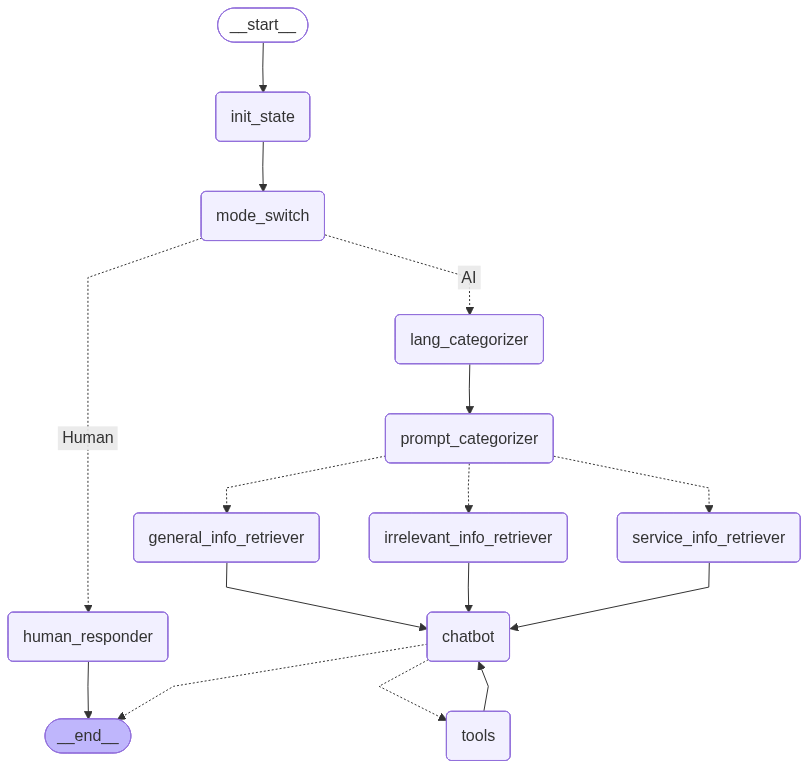

In [47]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

# Run Point

In [48]:
def run_customer_support(query: str)->Dict[str, str]:
  results = app.invoke({"messages": query}, {"configurable": {"thread_id": "1"}})
  return {
      "category":results['category'],
      "auto_mode":results['auto_mode'],
    #   "sentiment":results['sentiment'],
    # "is_follow_up": results['is_follow_up'],
      "messages": results['messages']
  }
query = "01975623344"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"AI Mode: {result['auto_mode']}")
# print(f"is_follow_up: {result['is_follow_up']}")
# print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['messages'][-1].content}")
print("\n")

Query: 01975623344
Category: irrelevant_query
AI Mode: True
Response: Thanks for sharing your contact number. How can we assist you with our professional home or office cleaning services today?


